In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Project Topic

The goal of this project is to predict prison sentence lengths for original sentences of primary charges in Cook County, Illinois, USA. The primary charge, according to Cook County, is the most severe charge, and cases are typically referred to by the primary charge.

The motivation behind this project is to explore features and uncover patterns related to prison sentencing lengths. This is an important task as the judicial system holds a lot of power, and a prison sentence can permanently impact many lives. Any unusual correlations or drivers of sentencing lengths can be quite impactful if identified.

Further studies can dive deeper into other sentencing types. It is important to note that biased sentencing or patterns will exist due to the nature of bias in the data collection, i.e., selective crime reporting.

The Linear Regression, Random Forest Regressor, and XGB models will be fitted to predict the sentence lengths in days. The Linear Regression model will serve as a baseline.

Due to the larger feature size (120+ after data cleaning and feature engineering), a Gradient Boost model was not used. However, due to the regularization and sampling ability, the XGB model was also selected for fitting.

While the RF model can typically be trained quicker than the XGB, due to the independent decision tree training capabilities, the XGB's sequential ensemble may have stronger predictive power on complex non-linear data.

While most of the features will be categorical and non-real, the SVM would also not be a great choice due to the size of the dataset (>10K rows). See the EDA and Machine Learning Notebook for more information.

In [2]:
df = pd.read_csv('Sentencing_20240531.csv', low_memory = False)

In [3]:
data = df.copy() # raw data copy for ease of iterative analysis

# Data

Cook County State's Attorney Office. (2024). Sentencing [Data set]. SAOData. https://datacatalog.cookcountyil.gov/Courts/Sentencing/tg8v-tm6u/about_data

The data used in this project is from the Cook County State's Attorney Office (CCSA). The data was downloaded on 5/31/24, and the data set was last updated on 2/22/24. The CCSA publishes updates quarterly and provides a simple CSV export function at the website linked above.

The raw CSV file is 152.2 MB and contains 41 columns and 294,622 rows. Each row represents a separate charge.

Each column has the following data type and non-null count:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294622 entries, 0 to 294621
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   CASE_ID                            294622 non-null  int64  
 1   CASE_PARTICIPANT_ID                294622 non-null  int64  
 2   RECEIVED_DATE                      294622 non-null  object 
 3   OFFENSE_CATEGORY                   294622 non-null  object 
 4   PRIMARY_CHARGE_FLAG                294622 non-null  bool   
 5   CHARGE_ID                          294622 non-null  int64  
 6   CHARGE_VERSION_ID                  294622 non-null  int64  
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  294622 non-null  object 
 8   CHARGE_COUNT                       294622 non-null  int64  
 9   DISPOSITION_DATE                   294622 non-null  object 
 10  DISPOSITION_CHARGED_CHAPTER        294622 non-null  object 
 11  DISPOSITION_CHARGED_ACT            2892

The CCSA provides the following feature descriptions, scraped from table "Columns in this Dataset" found at the link above:

In [5]:
pd.set_option('display.max_colwidth', None) # ease of reading the description from the table

desc = pd.read_csv('Feature Descriptions.csv')
desc

,Column Name,Description
0,CASE_ID,Internal unique identifier for each case
1,CASE_PARTICIPANT_ID,Internal unique identifier for each defendant associated with a case
2,RECEIVED_DATE,Date when Felony Review Unit received the case
3,OFFENSE_CATEGORY,Broad offense category before specific charges are filed on a case
4,PRIMARY_CHARGE_FLAG,A binary flag indicating whether this row records the most severe charge against the accused
5,CHARGE_ID,Internal unique identifier for each charge filed
6,CHARGE_VERSION_ID,Internal unique identifier for each version of a charge associated with charges filed
7,DISPOSITION_CHARGED_OFFENSE_TITLE,Specific title of the charged offense at disposition
8,CHARGE_COUNT,Number of charges associated with one defendant in one case
9,DISPOSITION_DATE,Date charge disposed


# Data Cleaning: Population Scope


The scope of this project was designed to study prison sentences assigned to the primary charge and for original sentences only. All other charge and cases will be dropped.

In [6]:
data['SENTENCE_PHASE'].value_counts()

Original Sentencing               282696
Probation Violation Sentencing      7384
Resentenced                         2121
Amended/Corrected Sentencing        2037
Remanded Sentencing                  378
Summary Charge Info                    6
Name: SENTENCE_PHASE, dtype: int64

In [7]:
data['SENTENCE_TYPE'].value_counts()

Prison                                           154023
Probation                                        112412
Jail                                              12257
Conditional Discharge                              4178
Supervision                                        3784
2nd Chance Probation                               3293
Cook County Boot Camp                              2768
Probation Terminated Unsatisfactorily               945
Conversion                                          277
Inpatient Mental Health Services                    275
Conditional Release                                 145
Probation Terminated Instanter                      117
Probation Terminated Satisfactorily                  77
Death                                                70
Vocational Rehabilitation Impact Center(VRIC)         1
Name: SENTENCE_TYPE, dtype: int64

In [8]:
data['CURRENT_SENTENCE_FLAG'].value_counts()

True     284390
False     10232
Name: CURRENT_SENTENCE_FLAG, dtype: int64

In [9]:
data['PRIMARY_CHARGE_FLAG'].value_counts()

True     210295
False     84327
Name: PRIMARY_CHARGE_FLAG, dtype: int64

In [10]:
data = data[(data['SENTENCE_TYPE']=='Prison')&(data['CURRENT_SENTENCE_FLAG']==True)&\
            (data['PRIMARY_CHARGE_FLAG']==True)&(data['SENTENCE_PHASE']=='Original Sentencing')].reset_index(drop = True)

Due to the nature of the data population including only prison sentences, the commitment type, according to Cook County, will most commonly be the Illinois Department of Corrections (IDC).

To simplify data modeling, the commitment type will be limited to IDC, in alignment with the Cook County glossary and guidelines.

In [11]:
data[['SENTENCE_TYPE','COMMITMENT_TYPE']].value_counts()

SENTENCE_TYPE  COMMITMENT_TYPE                         
Prison         Illinois Department of Corrections          92411
               Cook County Department of Corrections         325
               Probation                                     141
               Juvenile IDOC                                  42
               710/410 Probation                              23
               Intensive Probation Services                   17
               Drug Court Probation                           12
               Cook County Impact Incarceration Program       12
               Cook County Boot Camp                          11
               Mental Health Probation                         8
               Natural Life                                    3
               Gang Probation                                  2
               Intensive Drug Probation Services               2
               Court Supervision                               1
               Drug School        

In [12]:
data = data[data['COMMITMENT_TYPE']=='Illinois Department of Corrections'].reset_index(drop = True)

Primary Charge Flag, Sentence Type, Commitment Type, Sentence Phase, and Current Sentence Flag can be dropped as no further information can be gained.

In [13]:
data = data.drop(['COMMITMENT_TYPE','SENTENCE_TYPE','CURRENT_SENTENCE_FLAG','SENTENCE_PHASE',
                 'PRIMARY_CHARGE_FLAG'],
                axis = 1)

# Data Cleaning: Data Type Munging

Looking at the .info() table above, there appears to be a few date columns that are not in datetime.

In [14]:
date_col = data.columns[data.columns.str.contains('_DATE', case = False, na = False)] # identify all date columns
date_col

Index(['RECEIVED_DATE', 'DISPOSITION_DATE', 'SENTENCE_DATE',
       'INCIDENT_BEGIN_DATE', 'INCIDENT_END_DATE', 'ARREST_DATE',
       'FELONY_REVIEW_DATE', 'ARRAIGNMENT_DATE'],
      dtype='object')

In [15]:
data[date_col].sample(n = 5) # random view of 5 rows

,RECEIVED_DATE,DISPOSITION_DATE,SENTENCE_DATE,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,ARREST_DATE,FELONY_REVIEW_DATE,ARRAIGNMENT_DATE
69736,07/10/2017 12:00:00 AM,11/01/2017 12:00:00 AM,11/01/2017 12:00:00 AM,07/02/2017 12:00:00 AM,NaN,07/02/2017 04:27:00 PM,NaN,08/15/2017 12:00:00 AM
15460,10/12/2011 12:00:00 AM,02/14/2012 12:00:00 AM,02/14/2012 12:00:00 AM,10/06/2011 12:00:00 AM,NaN,10/06/2011 08:25:00 PM,NaN,11/16/2011 12:00:00 AM
89991,03/20/2022 12:00:00 AM,06/09/2023 12:00:00 AM,06/09/2023 12:00:00 AM,01/14/2022 12:00:00 AM,NaN,03/20/2022 09:00:00 AM,03/20/2022 12:00:00 AM,05/04/2022 12:00:00 AM
88083,06/16/2021 12:00:00 AM,06/01/2023 12:00:00 AM,06/01/2023 12:00:00 AM,06/09/2021 12:00:00 AM,NaN,NaN,06/16/2021 12:00:00 AM,11/30/2022 12:00:00 AM
44229,06/02/2014 12:00:00 AM,07/08/2014 12:00:00 AM,07/07/2014 12:00:00 AM,06/02/2014 12:00:00 AM,NaN,06/02/2014 05:10:00 AM,06/02/2014 12:00:00 AM,07/07/2014 12:00:00 AM


Check if the time is utilized across all 8 date fields

In [16]:
for col in date_col:
    print(col)
    print(data[col].str[11:].unique()) # search if there are various times for each date, or only 12:00:00 AM

RECEIVED_DATE
['12:00:00 AM']
DISPOSITION_DATE
['12:00:00 AM']
SENTENCE_DATE
['12:00:00 AM']
INCIDENT_BEGIN_DATE
['12:00:00 AM' nan]
INCIDENT_END_DATE
[nan '12:00:00 AM']
ARREST_DATE
['12:00:00 AM' '01:21:00 PM' '04:25:00 PM' ... '05:16:00 AM' '06:14:00 AM'
 '05:19:00 AM']
FELONY_REVIEW_DATE
[nan '12:00:00 AM']
ARRAIGNMENT_DATE
[nan '12:00:00 AM']


Since the time portion of the datetime does not appear to be used for all date columns except ARREST_DATE, the applicable seven date columns will be updated to a date only format.

In [17]:
data[date_col[date_col!='ARREST_DATE']] = data[date_col[date_col!='ARREST_DATE']].stack().str[:10].unstack()

It appears that there is an erroneous DISPOSITION_DATE:

In [18]:
data[data['DISPOSITION_DATE'].str.contains('2912')][date_col]

,RECEIVED_DATE,DISPOSITION_DATE,SENTENCE_DATE,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,ARREST_DATE,FELONY_REVIEW_DATE,ARRAIGNMENT_DATE
2538,01/03/2010,01/27/2912,01/27/2012,01/03/2010,NaN,01/03/2010 05:19:00 PM,01/03/2010,03/23/2010


In [19]:
def bar_label(ph):
    for rect in ph.patches:
        height = rect.get_height()
        width = rect.get_x() + rect.get_width() / 2
        if height>=0:
            count = round(((height)),4) # Getting the label for each bar within a plot
        else:
            height == 0
        plt.annotate(f'{count}', xy=(width, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
        
def year_comp_plot(date1,date2):
    plt.figure(figsize = (8,5))
    plt.title('Year Comparison Between '+str(date1)+' and '+ str(date2))
    year1 = data[date1].str[6:]
    year2 = data[date2].str[6:]
    if date1 == 'ARREST_DATE':
        year1 = data[date1].str[6:10]
    if date2 == 'ARREST_DATE':
        year2 = data[date2].str[6:10]
    plot_data = np.where(year1 == year2,'Same Year','Different Year') # plotting the count where the years match
    plot = sns.histplot(plot_data)
    bar_label(plot)

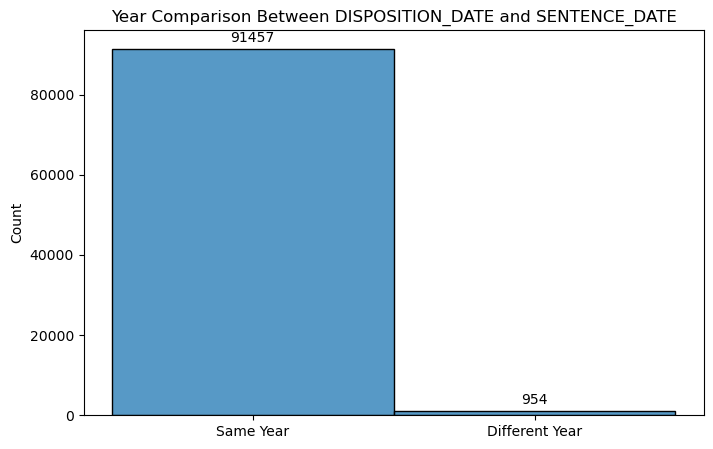

In [20]:
year_comp_plot('DISPOSITION_DATE','SENTENCE_DATE')

Since almost all of the Disposition Date years are equal to the Sentence Date years, we will impute the year of the erroneous Disposition Date as 2012.

In [21]:
data.loc[2538,'DISPOSITION_DATE'] = '01/27/2012'

Upon further inspection, there appears to be more errors with the years:
- Years that are greater than 2024 

In [22]:
future_year = {}
for col in date_col:
    if col != 'ARREST_DATE':
        print(col)
        index = data[col].dropna()[(data[col].str[6:].dropna().astype(int)>2024)].index
        print(str(len(index))+' Years > 2024') # print the number of cases where the year is past 2024 (present)
        future_year[col] = index
    else:
        print(col)
        index = data[col].dropna()[(data[col].str[6:10].dropna().astype(int)>2024)].index
        print(str(len(index))+' Years > 2024')
        future_year[col] = index

RECEIVED_DATE
0 Years > 2024
DISPOSITION_DATE
5 Years > 2024
SENTENCE_DATE
21 Years > 2024
INCIDENT_BEGIN_DATE
0 Years > 2024
INCIDENT_END_DATE
0 Years > 2024
ARREST_DATE
0 Years > 2024
FELONY_REVIEW_DATE
0 Years > 2024
ARRAIGNMENT_DATE
1 Years > 2024


Cleaning Disposition Dates > 2024

In [23]:
data.loc[future_year['DISPOSITION_DATE'],date_col]

,RECEIVED_DATE,DISPOSITION_DATE,SENTENCE_DATE,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,ARREST_DATE,FELONY_REVIEW_DATE,ARRAIGNMENT_DATE
46114,08/07/2014,02/03/2045,02/03/2015,08/03/2014,NaN,08/03/2014 09:45:00 PM,NaN,09/16/2014
61711,05/29/2016,01/24/2047,01/24/2017,05/27/2016,NaN,05/27/2016 10:40:00 PM,05/29/2016,06/21/2016
69109,06/04/2017,11/30/2107,11/30/2017,06/04/2017,NaN,06/04/2017 09:36:00 PM,06/04/2017,07/17/2017
80726,06/08/2019,12/31/2028,09/03/2021,06/08/2019,NaN,06/08/2019 07:20:00 PM,06/08/2019,07/11/2019
86554,12/26/2020,07/19/2921,07/19/2021,12/26/2020,NaN,12/26/2020 07:58:00 PM,12/26/2020,02/03/2021


From the graph above, it appears that the disposition dates are very close, if not the same as, the sentence dates. Since it is unlikely that all sentence years for the erroneous disposition dates are incorrect (we must still check for relative outlier dates), we will correct the disposition years using the sentence year.

In [24]:
data.loc[future_year['DISPOSITION_DATE'],'DISPOSITION_DATE'] = data.loc[future_year['DISPOSITION_DATE'],'DISPOSITION_DATE'].str[:6]+data.loc[future_year['DISPOSITION_DATE'],'SENTENCE_DATE'].str[6:]

Cleaning Sentence Dates > 2024

In [25]:
data.loc[future_year['SENTENCE_DATE'],date_col]

,RECEIVED_DATE,DISPOSITION_DATE,SENTENCE_DATE,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,ARREST_DATE,FELONY_REVIEW_DATE,ARRAIGNMENT_DATE
1963,08/30/2009,09/23/2011,09/23/2201,08/29/2009,NaN,08/29/2009 04:11:00 AM,08/30/2009,11/18/2009
17403,12/10/2011,06/26/2012,06/26/2212,12/10/2011,NaN,12/10/2011 07:00:00 PM,12/10/2011,01/19/2012
25252,08/28/2012,08/18/2014,08/07/2914,08/27/2012,NaN,08/27/2012 06:22:00 PM,08/28/2012,10/15/2012
25354,08/29/2012,10/31/2014,10/31/2914,08/28/2012,NaN,08/28/2012 01:18:00 AM,08/29/2012,07/16/2013
30798,02/24/2013,05/11/2015,05/11/2051,02/23/2013,NaN,02/23/2013 05:10:00 AM,02/24/2013,04/05/2013
37929,10/11/2013,06/24/2016,06/24/2026,09/30/2013,NaN,10/10/2013 03:29:00 PM,10/11/2013,11/21/2013
41254,02/13/2014,09/11/2014,09/11/2914,02/12/2014,NaN,02/12/2014 08:07:00 PM,02/13/2014,03/20/2014
56311,09/22/2015,08/23/2016,06/08/2026,09/20/2015,NaN,09/20/2015 10:40:00 PM,09/21/2015,10/13/2015
58070,12/04/2015,04/04/2016,04/04/2216,12/04/2015,NaN,12/04/2015 12:50:00 AM,12/04/2015,01/06/2016
58577,11/13/2015,10/03/2016,10/03/2026,10/30/2015,NaN,12/31/2015 10:34:00 PM,12/31/2015,02/05/2016


Just like the erroneous disposition dates, the erroneous sentence dates seem to be close to, if not identical to, the disposition dates. While all disposition dates do not appear to have an erroneous year, rows 80904 and 85706 have ambiguous month/year issues similar to those encountered during the cleaning of disposition dates. Therefore, these two rows will be dropped.

In [26]:
data.loc[future_year['SENTENCE_DATE'],'SENTENCE_DATE'] = data.loc[future_year['SENTENCE_DATE'],'SENTENCE_DATE'].str[:6]+data.loc[future_year['SENTENCE_DATE'],'DISPOSITION_DATE'].str[6:]

In [27]:
data = data.drop([80904,85706])

Cleaning Arraignment Date > 2024

In [28]:
data.loc[future_year['ARRAIGNMENT_DATE'],date_col]

,RECEIVED_DATE,DISPOSITION_DATE,SENTENCE_DATE,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,ARREST_DATE,FELONY_REVIEW_DATE,ARRAIGNMENT_DATE
67690,03/21/2017,05/18/2017,06/08/2017,03/21/2017,NaN,03/21/2017 12:35:00 PM,03/21/2017,04/20/2117


The arraignment date appears to be close to the felony review date. Due to the nature of the arraignment date, there can be a few months between the felony review date and the arraignment date. This means that felony review dates closer to the end of the year will likely have an arraignment date in a different year.

Because the felony review date is in March and the arraignment date is in April, the erroneous arraignment date will be corrected using the same felony review date year.

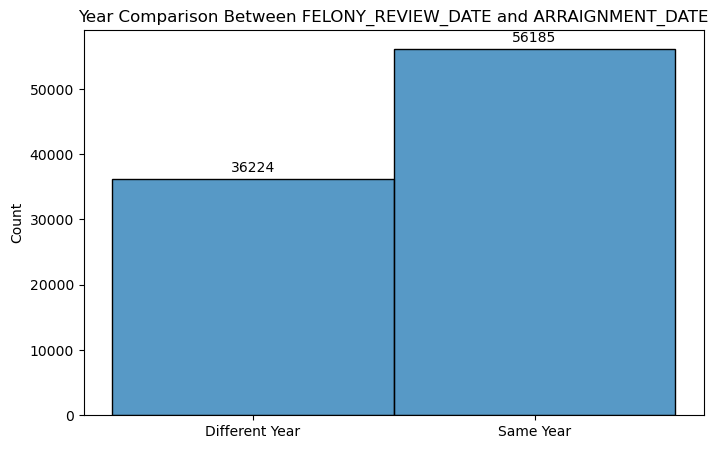

In [29]:
year_comp_plot('FELONY_REVIEW_DATE','ARRAIGNMENT_DATE')

<Axes: title={'center': 'Days Between Felony Review and Arraignment Date - No Outliers'}>

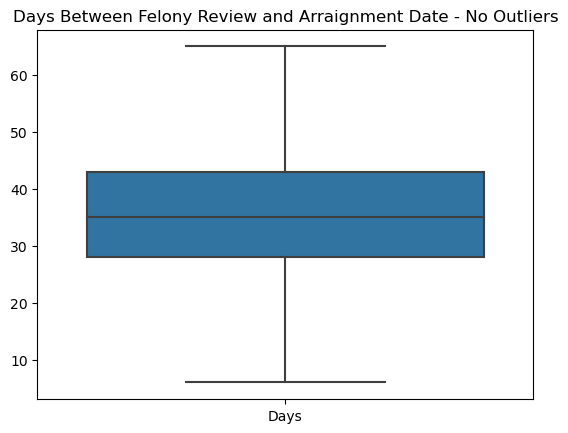

In [30]:
plt.title('Days Between Felony Review and Arraignment Date - No Outliers')
plt_df = pd.DataFrame((pd.to_datetime(data['ARRAIGNMENT_DATE'])-pd.to_datetime(data['FELONY_REVIEW_DATE'])).dropna().dt.days.reset_index(drop = True))
plt_df.columns = ['Days']
sns.boxplot(plt_df,showfliers = False) # hide outliers

In [31]:
data.loc[future_year['ARRAIGNMENT_DATE'],'ARRAIGNMENT_DATE'] = data.loc[future_year['ARRAIGNMENT_DATE'],'ARRAIGNMENT_DATE'].str[:6]+data.loc[future_year['ARRAIGNMENT_DATE'],'FELONY_REVIEW_DATE'].str[6:]

Assigning proper data types to the date columns

In [32]:
for col in date_col:
    data[col] = pd.to_datetime(data[col])

Commitment term also appears to be in an incorrect type

In [33]:
data['COMMITMENT_TERM'] = data['COMMITMENT_TERM'].astype(float)

# Data Cleaning: Null Values

Columns missing a lot of values (a high percentage of null values) are difficult to impute. However, if these columns represent potentially important information, the null values must be cleaned to be used for further analysis.

Columns that are not missing many values can be imputed much more easily. Similar rows, defined by matching values in other features, can be used to assign missing values.

In [34]:
null_vals = pd.concat([data.isnull().sum().sort_values(ascending = False)/len(data),
           data.isnull().sum().sort_values(ascending = False)], axis = 1)
null_vals.columns = ['Percent Null','Null Values']
null_vals = null_vals[null_vals['Percent Null']>0]
null_vals

,Percent Null,Null Values
CHARGE_DISPOSITION_REASON,0.999448,92358
INCIDENT_END_DATE,0.918385,84867
LAW_ENFORCEMENT_UNIT,0.683267,63140
FELONY_REVIEW_RESULT,0.279367,25816
FELONY_REVIEW_DATE,0.279367,25816
INCIDENT_CITY,0.068262,6308
ARRAIGNMENT_DATE,0.054616,5047
LENGTH_OF_CASE_in_Days,0.054616,5047
ARREST_DATE,0.027465,2538
DISPOSITION_CHARGED_ACT,0.017877,1652


The column 'CHARGE_DISPOSITION_REASON' [Additional information about the result of the charge] has over 99% null values.

The high volume of null values may not be enough to drop a column on its own. The feature description shows that this column provides additional information to 'CHARGE_DISPOSITION'.

In [35]:
data[data['CHARGE_DISPOSITION_REASON'].notnull()][['CHARGE_DISPOSITION',
                                                   'CHARGE_DISPOSITION_REASON']].value_counts()

CHARGE_DISPOSITION  CHARGE_DISPOSITION_REASON                           
Nolle Prosecution   PG to Other Count/s                                     19
                    Proceeding on Other Count/s                             11
Plea Of Guilty      Adjudicated Minor                                        8
Nolle Prosecution   Proceeding on Other Case/s                               3
                    Judgement & Conviction Vacated                           2
Case Dismissed      Drug Court Graduate                                      1
Finding Guilty      Adjudicated Minor                                        1
Nolle Prosecution   Motion to Quash Arrest & Suppress Evidence/Sustained     1
                    Nolle - AONIC                                            1
                    Re-Indictment                                            1
                    Warrant Quashed/Recalled                                 1
Plea Of Guilty      PG to Other Count/s                   

In [36]:
data[data['CHARGE_DISPOSITION_REASON'].notnull()][['CHARGE_ID',
                                                   'CHARGE_DISPOSITION',
                                                   'CHARGE_DISPOSITION_REASON',
                                                   'COMMITMENT_TERM','COMMITMENT_UNIT']]

,CHARGE_ID,CHARGE_DISPOSITION,CHARGE_DISPOSITION_REASON,COMMITMENT_TERM,COMMITMENT_UNIT
37,15942849940049,Nolle Prosecution,Proceeding on Other Count/s,70.0,Year(s)
98,20998074887938,Nolle Prosecution,PG to Other Count/s,6.0,Year(s)
243,20022813582100,Nolle Prosecution,Judgement & Conviction Vacated,25.0,Year(s)
266,20131480562697,Nolle Prosecution,PG to Other Count/s,25.0,Year(s)
1763,24800790943941,Nolle Prosecution,Proceeding on Other Count/s,21.0,Year(s)
3261,76127371192692,Nolle Prosecution,Motion to Quash Arrest & Suppress Evidence/Sustained,6.0,Year(s)
3307,76135572905303,Nolle Prosecution,PG to Other Count/s,6.0,Year(s)
3666,76163593519558,Nolle Prosecution,PG to Other Count/s,10.0,Year(s)
3944,76335886599380,Case Dismissed,Drug Court Graduate,1.0,Year(s)
4749,76986026534277,Nolle Prosecution,Proceeding on Other Count/s,15.0,Year(s)


There appears to be a lot of Nolle Prosecution entries for those with a Charge Disposition Reason. According to the Cook County Data glossary, Nolle Prosecution is used when the charge presented in the row is not pursued due to other charges.

For this project, both the charge disposition and the charge disposition reason are not necessary. This is because the project goal is to identify patterns and correlations driving sentence lengths. The charge disposition typically comes after the commitment term.

In [37]:
data = data.drop(['CHARGE_DISPOSITION','CHARGE_DISPOSITION_REASON'], axis = 1)

Removing Incident End Date and Felony Review Date and Felony Review Result
- From our analysis above, we have other important dates to consider for further feature engineering.
- The incident end date is not a column we can impute.
- The felony review date is also often close to the case received date, and not all cases go through felony review. Both columns related to the felony review can be dropped, as the nature of the felony will be identified through other features.

In [38]:
data = data.drop(['INCIDENT_END_DATE','FELONY_REVIEW_DATE','FELONY_REVIEW_RESULT'], axis = 1)

Removing Law Enforcement Unit
- Due to the high volume of NAs in the Law Enforcement Unit column, and most importantly, the small number of NAs in the Law Enforcement Agency column, the Unit column is dropped.

In [39]:
data = data.drop(['LAW_ENFORCEMENT_UNIT'], axis = 1)

Visualizing Remaining Null Values

<Axes: >

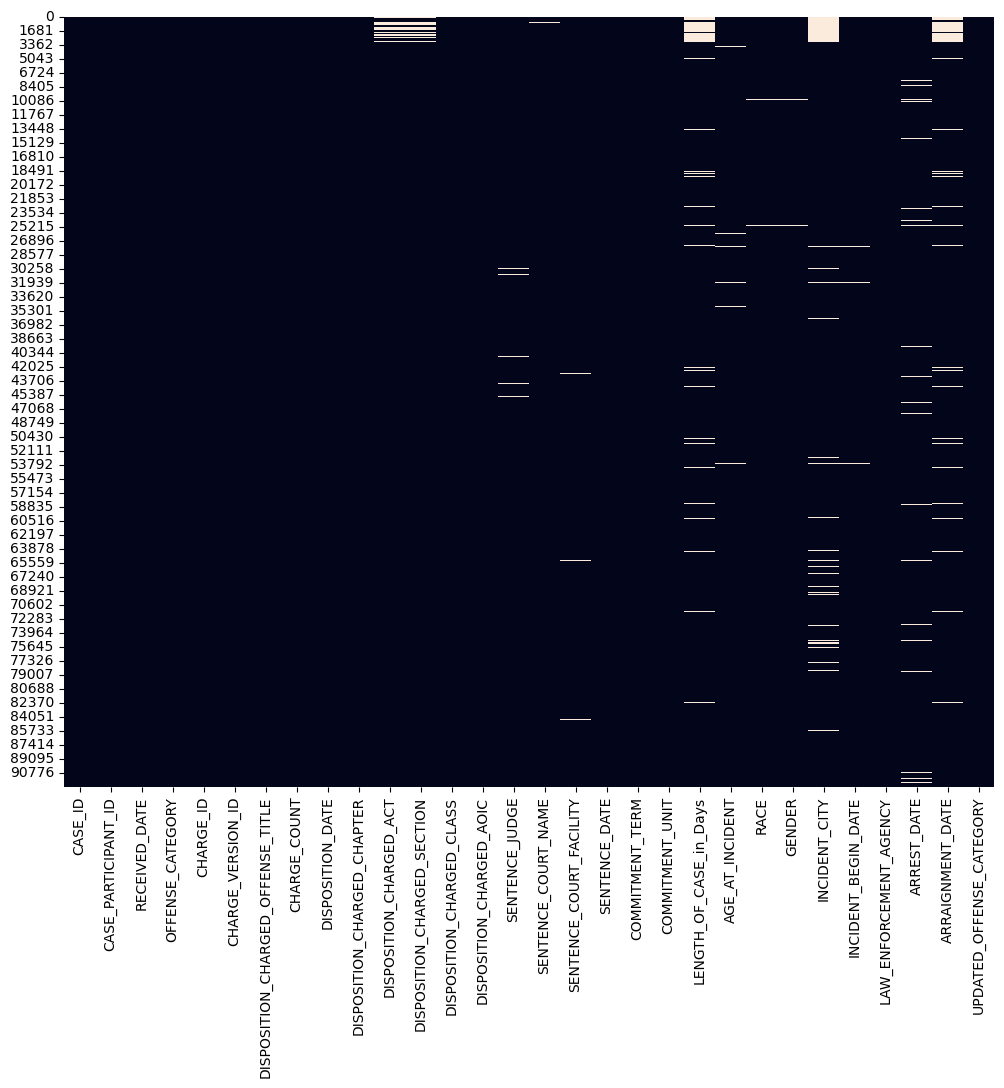

In [40]:
plt.figure(figsize = (12,10))
sns.heatmap(data.isnull(), cbar=False, xticklabels=True) # show where in data set the nulls are

There appears to be a cluster of incident cities missing at the beginning of the data set. Other columns with a high density of missing values at the beginning of the data set include the disposition-related columns and the arraignment date, which in turn impacts the length of the case in days due to the interaction of these variables.

# Data Cleaning: Null Values Continued

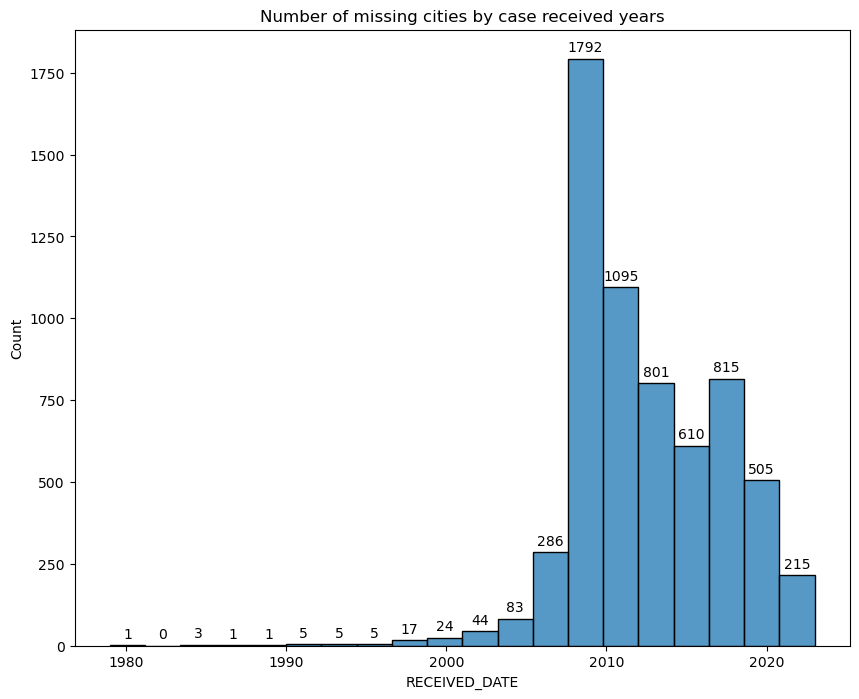

In [41]:
plt.figure(figsize = (10,8))
plt.title('Number of missing cities by case received years')

his_plot = sns.histplot(data[data['INCIDENT_CITY'].isnull()]['RECEIVED_DATE'].dt.year, bins = 20)
bar_label(his_plot)

There appears to be a few cases received in the late 1900s. These may be an outlier/mistake and could explain why the incident city was missing.

In [42]:
data.loc[data[data['INCIDENT_CITY'].isnull()]['RECEIVED_DATE'].idxmin(),:]

CASE_ID                                               280663370123
CASE_PARTICIPANT_ID                                   548344866796
RECEIVED_DATE                                  1979-11-20 00:00:00
OFFENSE_CATEGORY                                 Violate Bail Bond
CHARGE_ID                                           83914463242934
CHARGE_VERSION_ID                                     483380271132
DISPOSITION_CHARGED_OFFENSE_TITLE    VIO BAIL BOND/CLASS M OFFENSE
CHARGE_COUNT                                                     1
DISPOSITION_DATE                               2016-12-16 00:00:00
DISPOSITION_CHARGED_CHAPTER                                    720
DISPOSITION_CHARGED_ACT                                          5
DISPOSITION_CHARGED_SECTION                                  32-10
DISPOSITION_CHARGED_CLASS                                        X
DISPOSITION_CHARGED_AOIC                                   1415000
SENTENCE_JUDGE                               Lawrence Edward F

In [43]:
null_vals = pd.concat([data.isnull().sum().sort_values(ascending = False)/len(data),
           data.isnull().sum().sort_values(ascending = False)], axis = 1)
null_vals.columns = ['Percent Null','Null Values']
null_vals = null_vals[null_vals['Percent Null']>0]
null_vals

,Percent Null,Null Values
INCIDENT_CITY,0.068262,6308
ARRAIGNMENT_DATE,0.054616,5047
LENGTH_OF_CASE_in_Days,0.054616,5047
ARREST_DATE,0.027465,2538
DISPOSITION_CHARGED_ACT,0.017877,1652
DISPOSITION_CHARGED_SECTION,0.017877,1652
AGE_AT_INCIDENT,0.013559,1253
INCIDENT_BEGIN_DATE,0.010497,970
SENTENCE_COURT_FACILITY,0.005984,553
SENTENCE_COURT_NAME,0.004220,390


In [44]:
print('Data set without any null: '+ str(len(data.dropna())))
print('Current data set size: '+ str(len(data)))

print('\nTotal rows with at least one null: '+ str(len(data.dropna())-len(data))+' ,'+str(len(data.dropna())/len(data)-1))

Data set without any null: 80581
Current data set size: 92409

Total rows with at least one null: -11828 ,-0.1279961908472118


Since the columns contain a small number of missing values, and/or contain values of high importance, imputing does not seem reasonable.
- Arrest date, arraignment date, age, race, sentencing judge, gender, and city are some of the columns where imputing using an estimator does not seem reasonable.
- Dropping 11,828 rows makes sense for this task.

In [45]:
data = data.dropna().reset_index(drop = True)

# Data Cleaning: Outlier Dates

Outlier: Received - Arrest

In [46]:
data['receive_arrest'] = (data['RECEIVED_DATE']-data['ARREST_DATE']).dt.days

<Axes: title={'center': 'Distribution of days between Received Date - Arrest Date'}, xlabel='receive_arrest', ylabel='Count'>

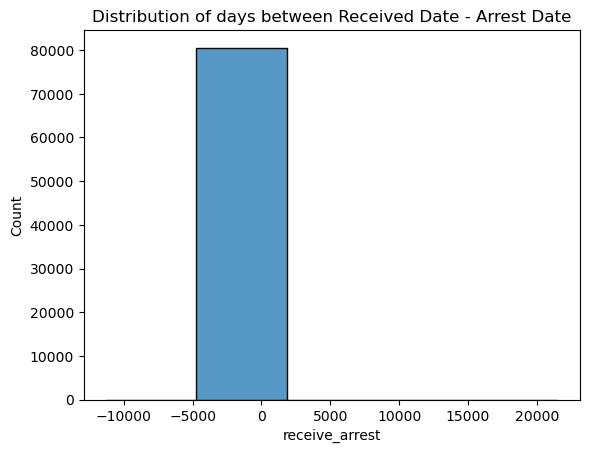

In [47]:
plt.title('Distribution of days between Received Date - Arrest Date')
sns.histplot(data, x = 'receive_arrest', bins= 5)

It appears that most of the cases have a case Received Date prior to an Arrest Date. Any cases that have an Arrest date prior to the Received date will be considered an outlier for this project and removed from the population.

In [48]:
data = data[data['receive_arrest']<=0]

Per Cook County, Arrests happen prior to Arraignments. Any cases where this is not the case will be dropped as an outlier.

In [49]:
print('Cases where arrests happen after the arraignment date: '+ str(sum(data['ARRAIGNMENT_DATE']<=data['ARREST_DATE'])))

Cases where arrests happen after the arraignment date: 85


In [50]:
data = data[data['ARRAIGNMENT_DATE']>data['ARREST_DATE']]

Per Cook County, Sentences happen after Arraignment. Any cases where this is not the case will be dropped as an outlier.

In [51]:
print('Cases where arraignments happen after the sentence date: '+ str(sum(data['SENTENCE_DATE']<=data['ARRAIGNMENT_DATE'])))

Cases where arraignments happen after the sentence date: 2536


In [52]:
data = data[data['SENTENCE_DATE']>data['ARRAIGNMENT_DATE']]

In [53]:
data['incident_arrest'] = (data['INCIDENT_BEGIN_DATE']-data['ARREST_DATE']).dt.days

<Axes: title={'center': 'Distribution of days between Incident Date - Arrest Date'}, xlabel='incident_arrest', ylabel='Count'>

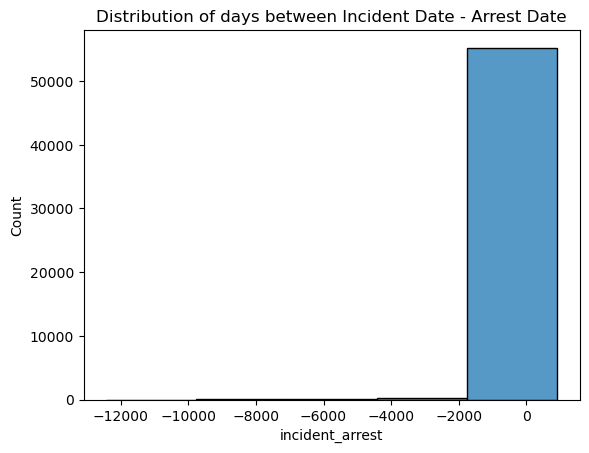

In [54]:
plt.title('Distribution of days between Incident Date - Arrest Date')
sns.histplot(data, x = 'incident_arrest', bins= 5)

It appears that most of the cases have a Incident Date prior to an Arrest Date. This makes sense, and any cases that have an Arrest date prior to the Incident date will be considered an outlier for this project and removed from the population.

In [55]:
data = data[data['incident_arrest']<=0].reset_index(drop = True)

In [56]:
data = data.drop(['receive_arrest','incident_arrest'], axis = 1)

# Data Cleaning: Out of Scope Columns / Features

- Case Participant ID, Case ID, Charge ID, Charge Version ID:
    - These features represent the unique identifiers for the case, participant, and charge. They do not contain any further information for EDA or to be used in the machine learning model, as only the primary charge is considered.
    
- Length of Case in Days:
    - This feature represents the passing of time (the difference between the Arraigned Date and Sentence Date) and will be feature engineered. This pre-existing column is not needed.
    
- Updated Offense Category:
    - This feature represents information that evolves as the case progresses. While important, it is unclear if this "update" occurs before or after the original sentence guidelines. Therefore, for this project, it is out of scope. The Offense Category column will be kept.
    
- Received Date:
    - This column represents the date the State's Attorney's office first touched the case. For the purposes of this project, other more pertinent date columns will be enriched through feature engineering.
    
- Disposition Charged Chapter, Act, and Section:
    - According to Cook County, these three columns together represent the Illinois criminal statute of the charges brought against the participant.
    
- Disposition Charged Offense Title:
    - As there are over 100 unique values, the combination of Offense Category and Disposition Charged Class will be kept to provide enough detail regarding crime type and severity.

In [57]:
data = data.drop(['CASE_PARTICIPANT_ID','CASE_ID','CHARGE_ID','CHARGE_VERSION_ID','LENGTH_OF_CASE_in_Days',
          'UPDATED_OFFENSE_CATEGORY','RECEIVED_DATE',
          'DISPOSITION_CHARGED_CHAPTER', 'DISPOSITION_CHARGED_ACT','DISPOSITION_CHARGED_SECTION',
                 'DISPOSITION_CHARGED_OFFENSE_TITLE'], axis = 1)

Number of unique values:
- This is used to identify good candidates for encoding categorical variables into dummy variables.
- Columns with too many unique values may not be great candidates to turn into dummy variables without further enrichment.

In [58]:
data.nunique().sort_values()

GENDER                           5
SENTENCE_COURT_NAME              6
COMMITMENT_UNIT                  7
RACE                             9
DISPOSITION_CHARGED_CLASS       12
SENTENCE_COURT_FACILITY         12
CHARGE_COUNT                    27
AGE_AT_INCIDENT                 66
OFFENSE_CATEGORY                84
COMMITMENT_TERM                143
INCIDENT_CITY                  156
LAW_ENFORCEMENT_AGENCY         213
SENTENCE_JUDGE                 236
DISPOSITION_CHARGED_AOIC      1018
SENTENCE_DATE                 3253
DISPOSITION_DATE              3277
ARRAIGNMENT_DATE              3291
INCIDENT_BEGIN_DATE           5266
ARREST_DATE                  50678
dtype: int64

Continue dropping of out of scope columns:

- Disposition AOIC
    - This feature represents the administrative office where the disposition was held. In this project, it will be considered out of scope due to the large number of unique offices (>1000).

In [59]:
data = data.drop(['DISPOSITION_CHARGED_AOIC'], axis = 1)

# Data Cleaning: Outlier Age

Text(0, 0.5, 'Age')

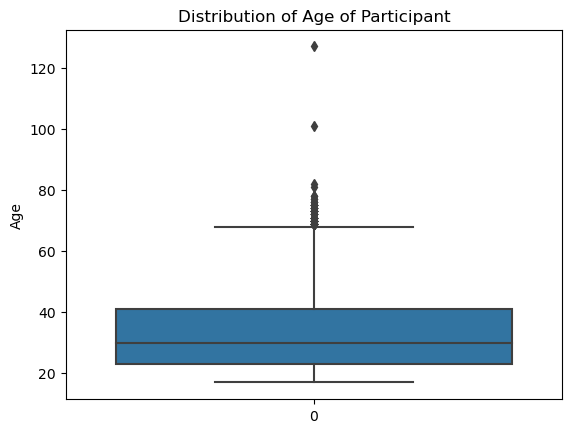

In [60]:
plt.title('Distribution of Age of Participant')
sns.boxplot(data['AGE_AT_INCIDENT'])
plt.ylabel('Age')

It appears highly unlikley for the two outlier participants to be over 100 years old. The oldest verified human was 122 years of age.

In [61]:
data[data['AGE_AT_INCIDENT']>100]

,OFFENSE_CATEGORY,CHARGE_COUNT,DISPOSITION_DATE,DISPOSITION_CHARGED_CLASS,SENTENCE_JUDGE,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,SENTENCE_DATE,COMMITMENT_TERM,COMMITMENT_UNIT,AGE_AT_INCIDENT,RACE,GENDER,INCIDENT_CITY,INCIDENT_BEGIN_DATE,LAW_ENFORCEMENT_AGENCY,ARREST_DATE,ARRAIGNMENT_DATE
39562,Driving With Suspended Or Revoked License,1,2018-09-05,4,Steven J Goebel,District 3 - Rolling Meadows,Rolling Meadows Courthouse,2018-09-05,1.0,Year(s),127.0,HISPANIC,Male,Hanover Park,2017-07-01,HANOVER PARK PD,2017-07-01 20:31:00,2018-01-19
52332,Aggravated Battery Police Officer,1,2022-09-21,2,Charles P Burns,District 1 - Chicago,26TH Street,2022-09-21,3.0,Year(s),101.0,Black,Male,Chicago,2021-07-04,CHICAGO PD,2021-07-04 23:17:00,2021-08-13


As age is an important feature, the two outliers are dropped due to high likelihood of error.

In [62]:
data = data[data['AGE_AT_INCIDENT']<100].reset_index(drop = True)

# Feature Engineering: Time

- Time Delta Related Features:
    - arrest_incident: Arrest Date - Incident Date. This is used to identify the duration of time it took before the participant was arrested after the crime. A potential hypothesis could be that a longer duration would indicate a participant who has been "on the run", suggesting a potentially higher severity.
    - sentence_arrest: Sentence Date - Arrest Date. This is used to identify the duration of time it took before the participant was sentenced after the arrest date. A potential hypothesis could be that a longer gap would indicate a more serious case, suggesting a potentially higher severity.

In [63]:
date_col = data.columns[data.columns.str.contains('_DATE', case = False, na = False)]

In [64]:
data['arrest_incident'] = (data['ARREST_DATE']-data['INCIDENT_BEGIN_DATE']).dt.days
data['sentence_arrest'] = (data['SENTENCE_DATE']-data['ARREST_DATE']).dt.days

- Circular Encoding Months:
    - Arrest Month, Disposition Month
    - Sine and cosine circular encoding will be created to assign the correct temporal relationship between month variables. For example, month 12 is closer to month 1 than it is to month 10, but without circular encoding, the temporal relationship is not known.
    - A potential hypothesis would explore a seasonality pattern in the severity of sentences throughout the year. For instance, dispositions or arrests around holiday seasons could result in more lenient sentences.

In [65]:
def circular_encoding(col):
    sin = np.sin(2 * np.pi * data[col].dt.month/12)
    cos = np.cos(2 * np.pi * data[col].dt.month/12)
    return sin, cos

In [66]:
data['sin_ARREST'] = circular_encoding('ARREST_DATE')[0]
data['cos_ARREST'] = circular_encoding('ARREST_DATE')[1]

data['sin_DISPOSITION'] = circular_encoding('DISPOSITION_DATE')[0]
data['cos_DISPOSITION'] = circular_encoding('DISPOSITION_DATE')[1]

- Keeping the Sentence Year only to represent the Case YEAR

Raw date columns are removed as they are no longer needed.

In [67]:
data['YEAR'] = data['SENTENCE_DATE'].dt.year

In [68]:
data = data.drop(date_col, axis = 1)

See EDA and Machine Learning notebook for further analysis regarding circular encoded data

# Data Cleaning: Gender

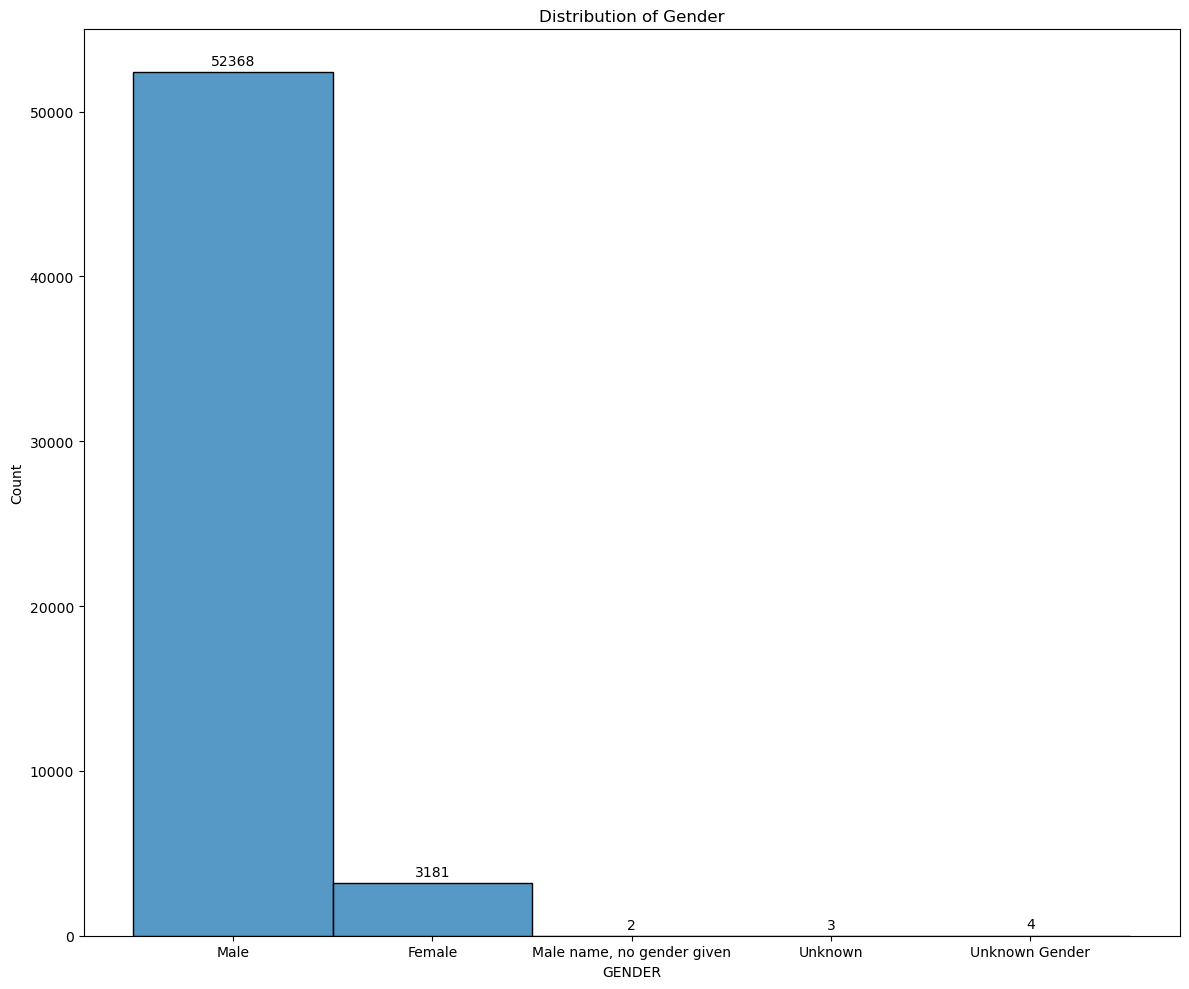

In [69]:
plt.figure(figsize = (12,10))
plt.title('Distribution of Gender')
gender_plt = sns.histplot(data['GENDER'])
bar_label(gender_plt)
plt.tight_layout()

It seems that there are two different types of "Unknown." One gender is implied from a male name.

Drop non-male or female genders.

In [70]:
data = data[data['GENDER'].isin(['Male','Female'])].reset_index(drop = True)

# Data Cleaning: Race

In [71]:
data['RACE'].value_counts()

Black                               39624
White [Hispanic or Latino]           8313
White                                6356
HISPANIC                              564
White/Black [Hispanic or Latino]      391
Asian                                 202
Unknown                                65
American Indian                        28
Biracial                                6
Name: RACE, dtype: int64

Unknown RACE will be dropped as it is not possible to impute.

Future iterations could consider further consolidation of the race groups.

In [72]:
data = data[data['RACE']!='Unknown'].reset_index(drop = True)

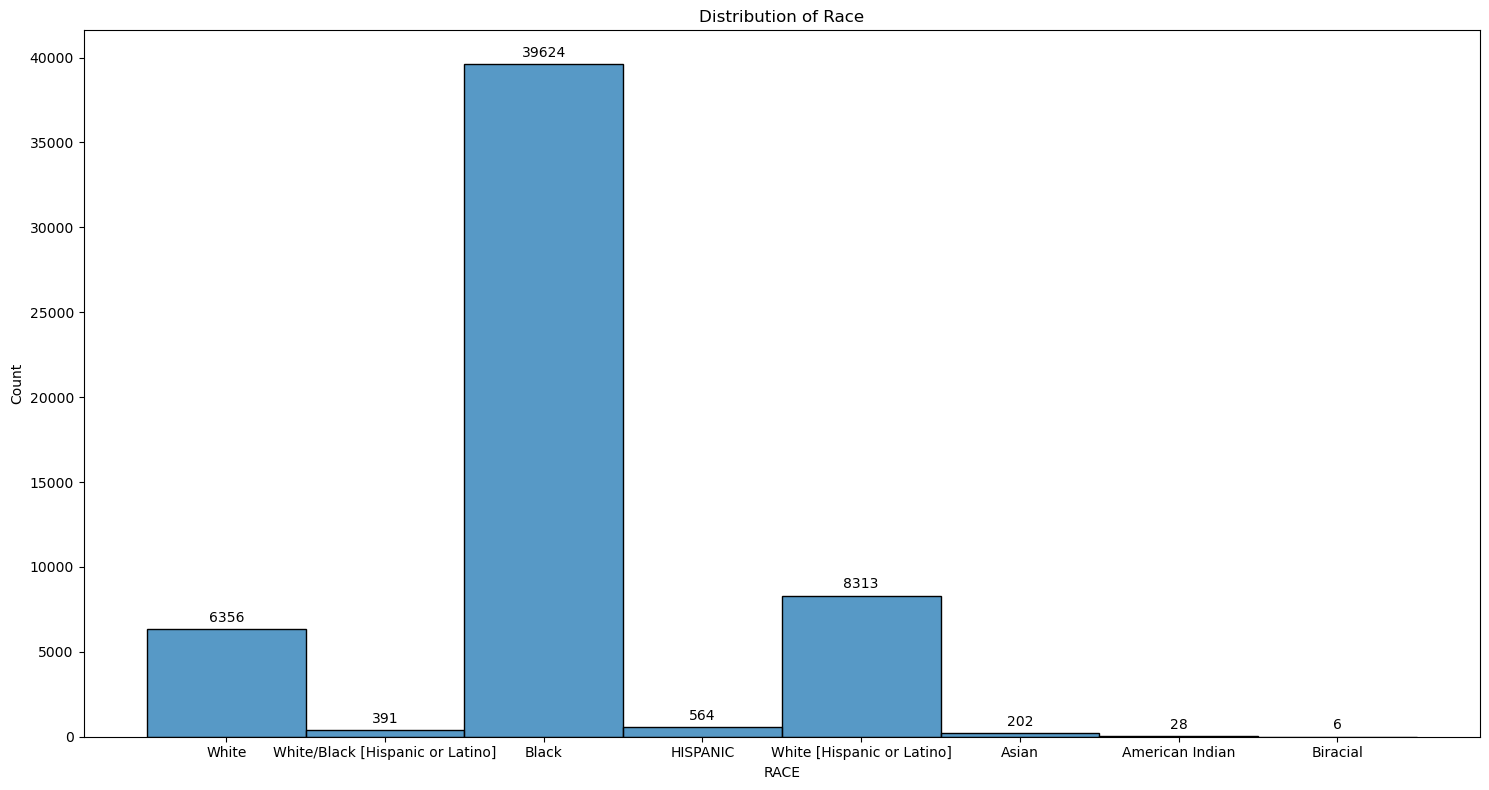

In [73]:
plt.figure(figsize = (15,8))
plt.title('Distribution of Race')
race_plt = sns.histplot(data['RACE'])
bar_label(race_plt)
plt.tight_layout()

# Feature Engineering: Standardizing Commitment Term
- Commitment Term in Days
    - Turn all commitment terms into days using the commitment unit.
    - Drop the commitment unit once complete

In [74]:
data['COMMITMENT_UNIT'].value_counts()

Year(s)         50305
Months           5098
Natural Life       42
Days               27
Term                8
Dollars             3
Hours               1
Name: COMMITMENT_UNIT, dtype: int64

Units Natural Life, Term, Dollars, and Hours are unusual.

In [75]:
data[data['COMMITMENT_UNIT'].isin(['Natural Life','Term','Dollars','Hours'])]\
.sort_values(by = 'COMMITMENT_UNIT')

,OFFENSE_CATEGORY,CHARGE_COUNT,DISPOSITION_CHARGED_CLASS,SENTENCE_JUDGE,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,COMMITMENT_TERM,COMMITMENT_UNIT,AGE_AT_INCIDENT,RACE,GENDER,INCIDENT_CITY,LAW_ENFORCEMENT_AGENCY,arrest_incident,sentence_arrest,sin_ARREST,cos_ARREST,sin_DISPOSITION,cos_DISPOSITION,YEAR
20110,Possession of Stolen Motor Vehicle,1,2,Joan Margaret O'Brien,District 5 - Bridgeview,Bridgeview Courthouse,6.0,Dollars,54.0,Black,Male,Chicago,CHICAGO PD,0,760,-8.660254e-01,5.000000e-01,-5.000000e-01,8.660254e-01,2015
36582,Burglary,1,2,Allen F Murphy,District 6 - Markham,Markham Courthouse,4.0,Dollars,54.0,Black,Male,South Holland,SOUTH HOLLAND PD,114,418,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,2017
7562,Driving With Suspended Or Revoked License,1,4,Colleen Ann Hyland,District 5 - Bridgeview,Bridgeview Courthouse,2.0,Dollars,39.0,White,Male,Palos Heights,PALOS HEIGHTS PD,0,124,-5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,2012
34085,UUW - Unlawful Use of Weapon,1,4,Alfredo Maldonado,District 1 - Chicago,26TH Street,1.0,Hours,22.0,Black,Male,Chicago,CHICAGO PD,0,195,5.000000e-01,-8.660254e-01,-5.000000e-01,8.660254e-01,2016
516,Armed Robbery,1,X,Timothy Joseph Joyce,District 1 - Chicago,26TH Street,1.0,Natural Life,48.0,Black,Male,Chicago,CHICAGO PD,0,1776,-5.000000e-01,-8.660254e-01,1.000000e+00,6.123234e-17,2015
19618,Homicide,1,M,Colleen Ann Hyland,District 5 - Bridgeview,Bridgeview Courthouse,0.0,Natural Life,51.0,White,Male,Palos Park,COOK COUNTY SHERIFF (IL0160000),1,851,-1.000000e+00,-1.836970e-16,5.000000e-01,8.660254e-01,2016
21639,Homicide,1,M,Joanne Rosado,District 1 - Chicago,26TH Street,1.0,Natural Life,19.0,Black,Male,Chicago,CHICAGO PD,21,3171,8.660254e-01,5.000000e-01,-8.660254e-01,5.000000e-01,2022
24543,Homicide,1,M,"Byrne, Thomas",District 1 - Chicago,26TH Street,1.0,Natural Life,23.0,Black,Male,Chicago,CHICAGO PD,231,3295,-8.660254e-01,-5.000000e-01,-8.660254e-01,-5.000000e-01,2023
24544,Homicide,1,M,"Byrne, Thomas",District 1 - Chicago,26TH Street,1.0,Natural Life,22.0,Black,Male,Chicago,CHICAGO PD,231,3295,-8.660254e-01,-5.000000e-01,-8.660254e-01,-5.000000e-01,2023
24883,Aggravated Battery With A Firearm,1,X,Maura Slattery Boyle,District 1 - Chicago,26TH Street,1.0,Natural Life,50.0,Black,Male,Chicago,CHICAGO PD,308,1740,-8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00,2019



Any cases where the commitment unit is in terms of dollars or hours will be dropped. The unit "term" is ambiguous in this instance and impossible to impute. "Dollar" and "hour" appear to be errors or outliers, as a prison sentence typically lasts longer than hours.

Natural life sentences with a duration of 0 will also be dropped.

In [76]:
data = data[(~data['COMMITMENT_UNIT'].isin(['Term','Dollars','Hours']))]

In [77]:
data = data[~((data['COMMITMENT_UNIT']=='Natural Life')&(data['COMMITMENT_TERM']==0))].reset_index(drop = True)

Natural life sentences mean that the participant is sentenced to prison for the rest of their lives. In order to compute this back to a sentence in days, the 95th percentile sentence length in years for the same age and offense class will be considered to convert the natural life sentence into years. Another potential method for approximating a natural life sentence could be 105 - age.

In [78]:
age_class_df = pd.DataFrame(data=[list(idx) for idx in data[data['COMMITMENT_UNIT']=='Natural Life'][['DISPOSITION_CHARGED_CLASS',
                                                                     'AGE_AT_INCIDENT']].value_counts().index],
                           columns = ['DISPOSITION_CHARGED_CLASS','AGE_AT_INCIDENT'])

In [79]:
for x in range(len(age_class_df)):
    c_class = age_class_df.iloc[x,0]
    age = age_class_df.iloc[x,1]
    result = data[(data['DISPOSITION_CHARGED_CLASS']==c_class)&(data['AGE_AT_INCIDENT']>=(age-2))\
&(data['AGE_AT_INCIDENT']<=(age+2))&(data['COMMITMENT_UNIT']=='Year(s)')].copy()
    if len(result)>0:
        year = result['COMMITMENT_TERM'].quantile(.95) # obtain 95th percentile sentence length for matching results
    else:
        year = np.nan
    age_class_df.loc[x,'Years'] = year

In [80]:
age_class_df

,DISPOSITION_CHARGED_CLASS,AGE_AT_INCIDENT,Years
0,M,19.0,55.50
1,M,21.0,64.40
2,M,22.0,65.00
3,M,23.0,65.00
4,M,28.0,65.00
5,M,34.0,52.90
6,X,48.0,21.00
7,X,23.0,25.00
8,X,32.0,25.00
9,X,37.0,25.00


In [81]:
for x in range(len(age_class_df)):
    c_class = age_class_df.iloc[x,0]
    age = age_class_df.iloc[x,1]
    year = age_class_df.iloc[x,2]
    index = data[(data['DISPOSITION_CHARGED_CLASS']==c_class)&(data['AGE_AT_INCIDENT']>=(age-2))\
&(data['AGE_AT_INCIDENT']<=(age+2))&(data['COMMITMENT_UNIT']=='Natural Life')].index
    data.loc[index,'COMMITMENT_UNIT'] = 'Year(s)'
    data.loc[index,'COMMITMENT_TERM'] = year

The following operations are performed on each commitment term/unit to convert the commitment term into days:

Years * 365, Months * 30

The Commitment Term Units feature can be dropped after standardization.

In [82]:
data['COMMITMENT_TERM'] = np.where(data['COMMITMENT_UNIT']=='Year(s)',data['COMMITMENT_TERM']*365,
        np.where(data['COMMITMENT_UNIT']=='Months',data['COMMITMENT_TERM']*30,data['COMMITMENT_TERM']))

In [83]:
data = data.drop(['COMMITMENT_UNIT'], axis = 1)

# Data Cleaning: Outlier Commitment Term

There appears to be a huge outlier commitment term:

<Axes: >

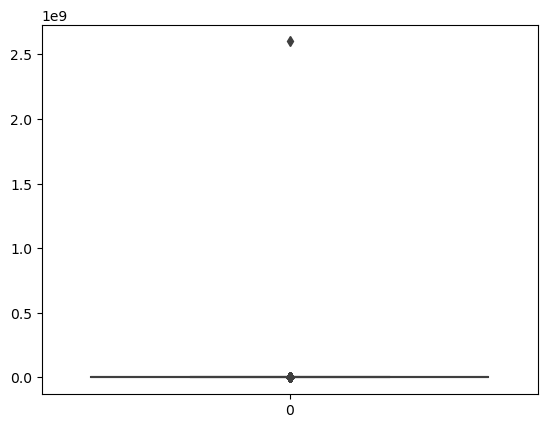

In [84]:
sns.boxplot(data['COMMITMENT_TERM'])

In [85]:
data.loc[data['COMMITMENT_TERM'].idxmax(),:]

OFFENSE_CATEGORY                                        UUW - Unlawful Use of Weapon
CHARGE_COUNT                                                                       1
DISPOSITION_CHARGED_CLASS                                                          2
SENTENCE_JUDGE                                                   Geraldine A D'Souza
SENTENCE_COURT_NAME                                             District 6 - Markham
SENTENCE_COURT_FACILITY                                           Markham Courthouse
COMMITMENT_TERM                                                         2599538395.0
AGE_AT_INCIDENT                                                                 23.0
RACE                                                                           Black
GENDER                                                                          Male
INCIDENT_CITY                                                                 Dolton
LAW_ENFORCEMENT_AGENCY       COOK COUNTY SHERIFF'S POLICE PATROL 

Outlier term is dropped.

In [86]:
data = data.drop(51263)

<Axes: >

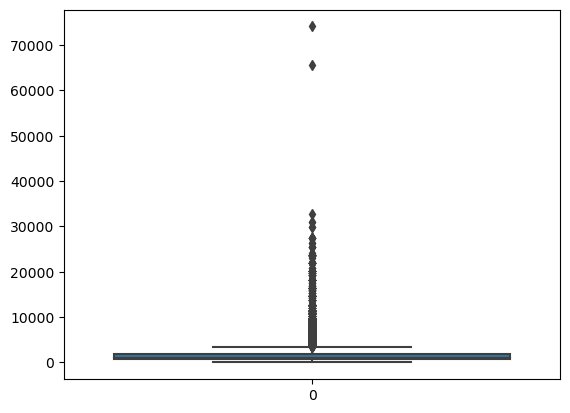

In [87]:
sns.boxplot(data['COMMITMENT_TERM'])

If an extreme sentence is considered > 99 years, or 36,165 days, there still appears to be two outliers with over 60,000 days.

In [88]:
data[data['COMMITMENT_TERM']>40000][['DISPOSITION_CHARGED_CLASS','OFFENSE_CATEGORY','AGE_AT_INCIDENT',
                                    'COMMITMENT_TERM']]

,DISPOSITION_CHARGED_CLASS,OFFENSE_CATEGORY,AGE_AT_INCIDENT,COMMITMENT_TERM
45817,1,Homicide,18.0,74095.0
48632,4,Burglary,44.0,65700.0


Since the severity of the crimes between outliers seems drastically different (homicide vs burglary), it is highly unlikely that the two errors would have had similar sentences.

Comparing the sentence length of other young participants, the outlier may have been caused by an additional 0 at the end of the sentence. It seems plausible that the true sentence was 20.3 years or 7409.5 days. However, since the commitment term is the predicted value, we will be dropping the outlier due to uncertainty.

In [89]:
data[(data['OFFENSE_CATEGORY']=='Homicide')&(data['DISPOSITION_CHARGED_CLASS']=='1')&\
    (data['AGE_AT_INCIDENT']<=20)]['COMMITMENT_TERM'].sort_values()

11329     1460.0
50991     1642.5
18643     2555.0
13855     2555.0
10228     2555.0
          ...   
33206     7300.0
32877     7300.0
14800     7300.0
19495     7300.0
45817    74095.0
Name: COMMITMENT_TERM, Length: 63, dtype: float64

Looking at other similar burglaries, it is unclear what the true commitment term should have been. The outlier is dropped due to the uncertainty.

In [90]:
data[(data['OFFENSE_CATEGORY']=='Burglary')&(data['DISPOSITION_CHARGED_CLASS']=='4')&\
    (data['AGE_AT_INCIDENT']<=46)&(data['AGE_AT_INCIDENT']>=42)]['COMMITMENT_TERM'].sort_values()

989        365.0
54261      365.0
53399      365.0
50965      365.0
50504      365.0
50432      365.0
48816      365.0
39335      365.0
18962      365.0
55240      365.0
29625      730.0
55167      730.0
41959      730.0
12951      730.0
10351      730.0
35495     1095.0
40091     1095.0
41387     1095.0
24182     1095.0
10491     1620.0
34013     1825.0
14053     1825.0
10023     1825.0
48632    65700.0
Name: COMMITMENT_TERM, dtype: float64

In [91]:
data = data.drop([45817,48632]).reset_index(drop = True)

See EDA and Machine Learning notebook for further analysis regarding commitment time and other continuous features

# Feature Engineering: Judge Names

As there are a lot of unique Judge Names, a simple encoding is not optimal. Instead, groups of judges will be created using the first Sentencing Year.

Prior to creating the group, however, Judge Names could be repeated but with different punctuations, spaces, etc.

In [92]:
from Levenshtein import distance as levenshtein_distance
judge_names = data['SENTENCE_JUDGE'].str.upper().replace(' ', '', regex=True).replace('[^\w\s]', '', regex=True).dropna().unique()

# Levenshtein distance calculates the number of charecter changes required to make two strings equal
def calculate_distance(judge1, judge2):
    score = levenshtein_distance(judge1, judge2)
    score = score / max(len(judge1),len(judge2)) # score is created by dividing the % different between strings
    return score

result_df = pd.DataFrame(columns = ['Judge','Matching_Judge','Score'])
for current_judge in judge_names:
    other_judges = [x for x in judge_names if x != current_judge] # compare judge name against all other judges
    best_score = 1
    for other_judge in other_judges:
        score = calculate_distance(current_judge, other_judge)
        if score < best_score:
            best_score = score # find the best score and matching judge name
            best_match = other_judge
    result_df.loc[len(result_df),:] = [current_judge, best_match, best_score]


In [93]:
result_df.sort_values(by = 'Score', ascending = True)[:10]

,Judge,Matching_Judge,Score
143,WILLIAMBRAINES,WILLIAMRAINES,0.071429
86,WILLIAMRAINES,WILLIAMBRAINES,0.071429
119,DONALDRHAVIS,RONALDSDAVIS,0.25
135,RONALDSDAVIS,DONALDRHAVIS,0.25
122,SUSANSULLIVAN,LAURAMSULLIVAN,0.285714
81,LAURAMSULLIVAN,SUSANSULLIVAN,0.285714
123,MICHAELKANE,MICHAELCLANCY,0.307692
89,MICHAELBHYMAN,MICHAELBROWN,0.307692
164,MICHAELCLANCY,MICHAELKANE,0.307692
64,MICHAELBROWN,MICHAELBHYMAN,0.307692


William B Raines and William Raines could be the same judge.

In [94]:
data[(data['SENTENCE_JUDGE'].str.contains('William', case = False, na = False))&\
(data['SENTENCE_JUDGE'].str.contains('Raines', case = False, na = False))][['YEAR','SENTENCE_COURT_NAME',
                                                                           'SENTENCE_COURT_FACILITY']].value_counts()

YEAR  SENTENCE_COURT_NAME      SENTENCE_COURT_FACILITY
2018  District 5 - Bridgeview  Bridgeview Courthouse      89
2019  District 1 - Chicago     26TH Street                80
2017  District 5 - Bridgeview  Bridgeview Courthouse      75
2021  District 1 - Chicago     26TH Street                56
2020  District 1 - Chicago     26TH Street                20
2022  District 1 - Chicago     26TH Street                13
2018  District 1 - Chicago     26TH Street                 3
2016  District 5 - Bridgeview  Bridgeview Courthouse       1
2023  District 1 - Chicago     26TH Street                 1
dtype: int64

Upon looking into William Raines, it appears that William B Raines is the only judge in the Cook County Judicial Circuit.

The judge name will be standardized to William Raines.

In [95]:
data['SENTENCE_JUDGE'] = np.where((data['SENTENCE_JUDGE'].str.contains('William', case = False, na = False))&\
(data['SENTENCE_JUDGE'].str.contains('Raines', case = False, na = False)),'William Raines',data['SENTENCE_JUDGE'])

- Groups of Judges by first Sentence Year
    - The data contains cases from 2011 to present.
    - Judges will be split into four groups using quantiles.

Drop judge name once complete.

In [96]:
judge_yrs = pd.DataFrame(data.groupby('SENTENCE_JUDGE')['YEAR'].min().copy()).reset_index()

In [97]:
judge_yrs['Judge_Group'] = np.where(judge_yrs['YEAR']<=judge_yrs['YEAR'].quantile(.25),'Oldest',
         np.where(judge_yrs['YEAR']<=judge_yrs['YEAR'].quantile(.5),'Moderate',
                  np.where(judge_yrs['YEAR']<=judge_yrs['YEAR'].quantile(.75),'New','Newest')))

In [98]:
data = pd.merge(data,judge_yrs[['Judge_Group','SENTENCE_JUDGE']], how = 'inner', on = 'SENTENCE_JUDGE')

In [99]:
data = data.drop('SENTENCE_JUDGE', axis = 1)

# Feature Engineering: City
- Creating a Chicago vs Non-Chicago Bucket
    - As there are over 100 unique cities in the data set, a binary group of cities will be created. Chicago is the largest city within Cook County and accounts for the most cases in the data set. A simple Incident in Chicago or Not in Chicago will be created.
    - While Sentence Court Name / Court Facility provides location information, the sentencing may not always be in the same city as the incident.

Dropping City once complete.

In [100]:
data[['INCIDENT_CITY','SENTENCE_COURT_NAME']].value_counts()

INCIDENT_CITY     SENTENCE_COURT_NAME         
Chicago           District 1 - Chicago            29744
                  District 2 - Skokie              6526
                  District 5 - Bridgeview          3617
Cicero            District 4 - Maywood              631
Harvey            District 6 - Markham              478
                                                  ...  
Hometown          District 1 - Chicago                1
                  District 6 - Markham                1
Olympia FIELDS    District 6 - Markham                1
Oakbrook Terrace  District 2 - Skokie                 1
Elmwood Park      District 3 - Rolling Meadows        1
Length: 315, dtype: int64

In [101]:
data['Incident_Chicago'] = np.where(data['INCIDENT_CITY']=='Chicago',1,0)

data = data.drop('INCIDENT_CITY', axis = 1)

# Data Cleaning: Droping Final Unused Columns

- Law Enforcement Agency:
    - While Law Enforcement Agency was originally kept instead of Law Enforcement Unit, the Incident_Chicago flag contains similar information regarding location. The Law Enforcement Agency would have likely been an agency from the same city as the incident. 
- Sentence Court Facility
    - The Sentence Court Name contains most of the information the Facility Name would have provided. Chicago contains 7 facilities, with most cases held at the 26th Street facility. All other court names only have one court facility.

In [102]:
data.groupby('SENTENCE_COURT_NAME')['SENTENCE_COURT_FACILITY'].value_counts()

SENTENCE_COURT_NAME           SENTENCE_COURT_FACILITY     
District 1 - Chicago          26TH Street                     30062
                              DV Courthouse                      37
                              Harrison & Kedzie (Area 4)         10
                              727 E. 111th Street (Area 2)        3
                              Belmont & Western (Area 3)          3
                              51st & Wentworth (Area 1)           2
                              Grand & Central (Area 5)            1
District 2 - Skokie           Skokie Courthouse                8235
District 3 - Rolling Meadows  Rolling Meadows Courthouse       2453
District 4 - Maywood          Maywood Courthouse               3217
District 5 - Bridgeview       Bridgeview Courthouse            6729
District 6 - Markham          Markham Courthouse               4711
Name: SENTENCE_COURT_FACILITY, dtype: int64

In [103]:
data = data.drop(['LAW_ENFORCEMENT_AGENCY','SENTENCE_COURT_FACILITY'], axis = 1)

# Feature Engineering Dummy Variables
- Gender, Incident Chicago, Judge Group, Sentence Court Name, Race, Disposition Charged Class, Offense Category
    - Incident Chicago is already one hot encoded.

The above categorical variables will be encoded into dummy variables, dropping the first for k-1 categories.
- See EDA and Machine Learning notebook for further analysis regarding categorical data

In [104]:
data.nunique().sort_values()

Incident_Chicago                2
GENDER                          2
Judge_Group                     4
SENTENCE_COURT_NAME             6
RACE                            8
sin_ARREST                     11
sin_DISPOSITION                11
DISPOSITION_CHARGED_CLASS      12
cos_DISPOSITION                12
cos_ARREST                     12
YEAR                           15
CHARGE_COUNT                   27
AGE_AT_INCIDENT                64
OFFENSE_CATEGORY               84
COMMITMENT_TERM               207
arrest_incident              1356
sentence_arrest              1967
dtype: int64

In [105]:
data.isnull().sum()

OFFENSE_CATEGORY             0
CHARGE_COUNT                 0
DISPOSITION_CHARGED_CLASS    0
SENTENCE_COURT_NAME          0
COMMITMENT_TERM              0
AGE_AT_INCIDENT              0
RACE                         0
GENDER                       0
arrest_incident              0
sentence_arrest              0
sin_ARREST                   0
cos_ARREST                   0
sin_DISPOSITION              0
cos_DISPOSITION              0
YEAR                         0
Judge_Group                  0
Incident_Chicago             0
dtype: int64

In [106]:
data_dummy = pd.get_dummies(data, columns = ['GENDER','OFFENSE_CATEGORY','DISPOSITION_CHARGED_CLASS','SENTENCE_COURT_NAME',
                              'RACE','Judge_Group'], drop_first=True).reset_index(drop = True)
# drop first to remove the redundant column

# Export Data to Pickle for EDA

In [107]:
data_dummy.to_pickle('data_dummy.pkl')
data.to_pickle('data.pkl')

# Summary: Data Cleaning

In [108]:
# No Dummy Variable
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55463 entries, 0 to 55462
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFENSE_CATEGORY           55463 non-null  object 
 1   CHARGE_COUNT               55463 non-null  int64  
 2   DISPOSITION_CHARGED_CLASS  55463 non-null  object 
 3   SENTENCE_COURT_NAME        55463 non-null  object 
 4   COMMITMENT_TERM            55463 non-null  float64
 5   AGE_AT_INCIDENT            55463 non-null  float64
 6   RACE                       55463 non-null  object 
 7   GENDER                     55463 non-null  object 
 8   arrest_incident            55463 non-null  int64  
 9   sentence_arrest            55463 non-null  int64  
 10  sin_ARREST                 55463 non-null  float64
 11  cos_ARREST                 55463 non-null  float64
 12  sin_DISPOSITION            55463 non-null  float64
 13  cos_DISPOSITION            55463 non-null  flo

In [109]:
# with Dummy Variables
data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55463 entries, 0 to 55462
Columns: 121 entries, CHARGE_COUNT to Judge_Group_Oldest
dtypes: float64(6), int64(5), uint8(110)
memory usage: 10.5 MB


# Summary: Data Cleaning
After data cleaning, the dataset has the following dimensions:
- The cleaned pickle file is 12MB.
- The cleaned dataset contains 121 columns and 55,463 rows.
- There were 17 features prior to dummy variable encoding:
    - 7 features were categorical:
        - Gender, Offense Category, Disposition Charged Class, Sentence Court Name, Race, Judge Group, Incident Chicago.
    - 10 features were continuous variables, including the independent variable COMMITMENT_TERM:
        - Age, Charge Count, Year, Cosine and Sine of Disposition Month, Cosine and Sine of Arrest Month, Days between Sentence and Arrest Date, Days between Arrest and Incident Date, Commitment Term.

Outlier years were identified by first checking for any years greater than 2024. Outlier dates include cases where the receive date is after the arrest date, where the arrest occurs prior to the arraignment, where sentences occur prior to the arraignment, and where the incident date is after the arrest. All outlier years were corrected if the date or year was not ambiguous, and all outlier dates were removed if not imputable.

24 total features were dropped due to unrelated scope, containing a vast number of NAs, or were confirmed to have similar other features that provide similar information.

The month of the arrest and disposition were circular encoded using cosine and sine encoding. All categorical variables were turned into dummy variables, removing k-1 features to ensure there were no columns that did not contribute information.

Please refer to further feature engineering within the EDA and Machine Learning notebook. Some potential future difficulties lie in the large number of unique values within some categorical variables. Although extensive data cleaning was performed to rectify errors, fill missing values, treat outliers, and drop features providing redundant or irrelevant information, there are still columns with a high number of unique values. This may pose a challenge in both statistical modeling and machine learning applications due to the weakness in some of the features that were turned into dummy variables.